# Motor Imagery Dataset Reading and Preprocessing

This notebook describes how to read and preprocess a MI dataset for central neural pain classification. The preprocessing steps include data loading, channel selection, filtering, segmentation, and baseline correction, in preparation for subsequent classification model training.

In [1]:
import sys
from pathlib import Path

root_dir = None

if 'google.colab' in sys.modules:
  print("Running on Google Colab")
  root_dir = Path("/content/drive/MyDrive/data/data_keri")
else:
  root_dir = Path("/Volumes/Public/data_keri")

set_files_all = list(root_dir.rglob("*.set"))
set_files_all = [f for f in set_files_all if "Unused AB" not in f.parts]
set_files_RS = list(root_dir.rglob("*_EC.set")) + list(root_dir.rglob("*_EO.set")) + list(root_dir.rglob("*_baseline.set"))
set_files_RS = [f for f in set_files_RS if "Unused AB" not in f.parts]
set_files_MI = [f for f in set_files_all if f not in set_files_RS and f.suffix == ".set"]

print(f"Find {len(set_files_all)} Files in Total")
print(f"Find {len(set_files_RS)} Resting State Files")
print(f"Find {len(set_files_MI)} Motor Imagery Files")

Find 360 Files in Total
Find 149 Resting State Files
Find 211 Motor Imagery Files


In [2]:
import mne
mne.set_log_level('ERROR')

def load_all_epochs_to_nme(file_list, set_table):
    """
    Load all epochs from a list of files and assign labels based on the provided set_table.
    Args:
        file_list (list): List of file paths to load epochs from.
        set_table (dict): Dictionary mapping labels to their corresponding values.
    Returns:
        epochs (list): List of loaded epochs.
        labels (list): List of labels corresponding to the loaded epochs.
    """
    epochs = []
    labels = []
    for f in file_list:
        try:
            ep = mne.read_epochs_eeglab(str(f))

            label = [key for key in set_table.keys() if key in f.parts]
            if label:
                label_value = set_table[label[0]]
                epochs.append(ep)
                labels.append(label_value)
            else:
                print(f"No label found for file: {f}")
        except Exception as e:
            print(f"Error processing {f}: {e}")

    return epochs, labels



MI_labels = {'PwP' : 0, 'PnP' : 1, 'PdP' : 2, 'AB' : 3}

epochs_list, labels = load_all_epochs_to_nme(set_files_MI, MI_labels)

In [3]:
def eeg_epoch_preprocessing(epoch):
    # Bandpass filter
    epoch = epoch.filter(l_freq=.1, h_freq=100., fir_design='firwin')
    # Apply notch filter
    epoch._data = mne.filter.notch_filter(
        epoch._data, epoch.info['sfreq'], 
        freqs=50., notch_widths=5., 
        fir_design='firwin'
    )
    return epoch

def eeg_epoch_cropping(epoch, crop_duration=2.0):
    duration = epoch.times[-1] - epoch.times[0]
    new_start = duration - crop_duration
    return epoch.copy().crop(tmin=new_start, tmax=None)

import pandas as pd

def eeg_epochs_preprocessing_with_labels(epochs_list, labels_list, crop_duration=2.0):
    """
    循环处理 Epochs 列表，并为每个对象添加标签。
    """
    if len(epochs_list) != len(labels_list):
        raise ValueError("The length of epochs_list and labels_list must be the same.")
        
    final_epochs_list = []
    # 使用 enumerate 来同时获取索引和 epoch 对象
    for i, eh in enumerate(epochs_list):
        # Step 1: 调用滤波函数
        preprocessed_epoch = eeg_epoch_preprocessing(eh)
        
        # Step 2: 调用裁剪函数
        cropped_epoch = eeg_epoch_cropping(preprocessed_epoch, crop_duration=crop_duration)
        
        # Step 3: 为处理完的 epoch 添加标签信息
        label = labels_list[i]
        num_trials = len(cropped_epoch)
        metadata = pd.DataFrame({'label': [label] * num_trials})
        cropped_epoch.metadata = metadata
        
        final_epochs_list.append(cropped_epoch)
        
    return final_epochs_list

# 使用
epochs_list_processed = eeg_epochs_preprocessing_with_labels(epochs_list, labels)


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# --- 开始你的分割流程 ---

# Step 1: 创建文件索引
# 这里的 "raws" 对应你的 "epochs_list_processed"
file_indices = np.arange(len(epochs_list_processed))
print(f"Total {len(file_indices)} files ready for splitting.")

# Step 2: 分割训练集 (80%) 和测试集 (20%)
# 注意：你的原始代码是70/30，这里根据你后来的要求调整为80/20
# test_size=0.3 对应 70/30, test_size=0.2 对应 80/20
train_val_indices, test_indices = train_test_split(
    file_indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Step 3: 为第二次分割准备临时标签列表
train_val_labels = [labels[i] for i in train_val_indices]

# Step 4: 分割验证集 (占原始数据的 20%*80% = 16%) 和训练集 (64%)
# test_size=0.25 意味着从80%中分出20%，即 80% * 0.25 = 20% 作为验证集
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25, # 0.25 * 0.8 = 0.2
    stratify=train_val_labels,
    random_state=42
)

# Step 5: 根据索引创建各数据集的 Epochs 对象列表
train_list = [epochs_list_processed[i] for i in train_indices]
val_list = [epochs_list_processed[i] for i in val_indices]
test_list = [epochs_list_processed[i] for i in test_indices]

print("\nSplitting complete. Number of files in each set:")
print(f"Training set:   {len(train_list)} files")
print(f"Validation set: {len(val_list)} files")
print(f"Test set:       {len(test_list)} files")


# Step 6: (关键) 将每个列表中的 Epochs 对象合并成一个大的 Epochs 对象
# 此时不再需要 run_raw_pipeline，因为数据已处理完毕
print("\nConcatenating epochs for each set...")
epochs_train = mne.concatenate_epochs(train_list)
epochs_val = mne.concatenate_epochs(val_list)
epochs_test = mne.concatenate_epochs(test_list)


# --- 最终验证 ---
print("\n--- Final Datasets ---")
print(f"Train data shape:      {epochs_train.get_data().shape}")
print(f"Validation data shape: {epochs_val.get_data().shape}")
print(f"Test data shape:       {epochs_test.get_data().shape}")

# 标签也已经自动合并在 metadata 中
y_train = epochs_train.metadata['label'].values
y_val = epochs_val.metadata['label'].values
y_test = epochs_test.metadata['label'].values

print(f"\nTrain labels shape:      {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape:       {y_test.shape}")

Total 211 files ready for splitting.

Splitting complete. Number of files in each set:
Training set:   126 files
Validation set: 42 files
Test set:       43 files

Concatenating epochs for each set...

--- Final Datasets ---
Train data shape:      (7215, 64, 257)
Validation data shape: (2463, 64, 257)
Test data shape:       (2459, 64, 257)

Train labels shape:      (7215,)
Validation labels shape: (2463,)
Test labels shape:       (2459,)


In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import mne

def find_optimal_n_components(epochs_train, variance_threshold=0.95):
    """
    在整个训练集上拟合一个PCA模型，以确定达到方差阈值所需的组件数。

    Args:
        epochs_train (mne.Epochs): 训练集数据。
        variance_threshold (float): 希望保留的方差比例，介于0和1之间。

    Returns:
        int: 达到阈值所需的最小组件数。
    """
    print(f"Finding optimal n_components to explain {variance_threshold * 100:.0f}% of variance...")
    
    # 1. 准备整个训练集的数据
    data_train = epochs_train.get_data()
    n_epochs, n_channels, n_times = data_train.shape
    data_reshaped = data_train.transpose(0, 2, 1).reshape(-1, n_channels)
    
    # 2. 拟合一个包含所有组件的PCA模型
    # n_components=None 会自动设为 min(n_samples, n_features)
    pca = PCA(n_components=None, random_state=42)
    pca.fit(data_reshaped)
    
    # 3. 计算累计解释方差
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # 4. 找到刚好超过阈值的组件数
    # np.searchsorted 会找到第一个 cumulative_variance >= threshold 的索引
    optimal_n = np.searchsorted(cumulative_variance, variance_threshold) + 1
    
    print(f"  - Optimal number of components found: {optimal_n}")
    print(f"  - These {optimal_n} components explain {cumulative_variance[optimal_n-1] * 100:.2f}% of the variance.")
    
    return optimal_n

def apply_cpa_with_sklearn_auto(epochs_train, epochs_val, epochs_test, variance_threshold=0.95):
    """
    自动确定维度并执行CPA降维。
    """
    # 自动确定最佳维度
    n_components_auto = find_optimal_n_components(epochs_train, variance_threshold)
    
    # 后续流程与你原来的函数完全相同，只是 n_components 不再是硬编码
    # ... (此处省略与你原函数相同的代码，为了简洁) ...
    # 1. 在训练集上为每个类别拟合一个 sklearn.PCA 模型
    print("\nFitting sklearn PCA models on the training set with auto-determined components...")
    cpa_models = {}
    unique_labels = sorted(epochs_train.metadata['label'].unique())
    
    for label in unique_labels:
        epochs_class = epochs_train[epochs_train.metadata['label'] == label]
        data_class = epochs_class.get_data()
        n_epochs, n_channels, n_times = data_class.shape
        data_reshaped = data_class.transpose(0, 2, 1).reshape(-1, n_channels)
        
        # 使用自动计算出的维度
        pca = PCA(n_components=n_components_auto, random_state=42)
        pca.fit(data_reshaped)
        cpa_models[label] = pca
        print(f"  - Fitted PCA for label '{label}' with {n_channels} -> {n_components_auto} components.")

    # 2. 定义辅助函数 transform_epochs (与你原函数完全相同)
    def transform_epochs(epochs, models):
        if epochs is None or len(epochs) == 0: return None
        original_info = epochs.info
        original_tmin = epochs.tmin
        transformed_data_list, metadata_list = [], []
        
        for label, model in models.items():
            epochs_subset = epochs[epochs.metadata['label'] == label]
            if len(epochs_subset) > 0:
                data_subset = epochs_subset.get_data()
                n_sub_epochs, n_sub_channels, n_sub_times = data_subset.shape
                reshaped_subset = data_subset.transpose(0, 2, 1).reshape(-1, n_sub_channels)
                transformed_reshaped = model.transform(reshaped_subset)
                final_data = transformed_reshaped.reshape(n_sub_epochs, n_sub_times, n_components_auto).transpose(0, 2, 1)
                transformed_data_list.append(final_data)
                metadata_list.append(epochs_subset.metadata)

        if not transformed_data_list: return None
        all_transformed_data = np.concatenate(transformed_data_list, axis=0)
        all_metadata = pd.concat(metadata_list, ignore_index=True)
        new_ch_names = [f'CPA_{i+1}' for i in range(n_components_auto)]
        new_info = mne.create_info(ch_names=new_ch_names, sfreq=original_info['sfreq'], ch_types='eeg')
        return mne.EpochsArray(all_transformed_data, info=new_info, tmin=original_tmin, metadata=all_metadata)

    # 3. 应用模型
    print("\nApplying sklearn PCA models to train, validation, and test sets...")
    epochs_train_cpa = transform_epochs(epochs_train, cpa_models)
    print("  - Applied to training set.")
    epochs_val_cpa = transform_epochs(epochs_val, cpa_models)
    print("  - Applied to validation set.")
    epochs_test_cpa = transform_epochs(epochs_test, cpa_models)
    print("  - Applied to test set.")
    print(f"\nCPA complete. Data dimension automatically reduced to {n_components_auto} channels.")
    
    return epochs_train_cpa, epochs_val_cpa, epochs_test_cpa

# --- 如何使用 ---

# 现在你不再需要手动设定 N_COMPONENTS
# 你可以设定一个你想要的方差保留率，比如 0.95 (95%)
VARIANCE_TO_KEEP = 0.95

epochs_train_cpa, epochs_val_cpa, epochs_test_cpa = apply_cpa_with_sklearn_auto(
    epochs_train, 
    epochs_val, 
    epochs_test, 
    variance_threshold=VARIANCE_TO_KEEP
)

# 检查降维后的数据维度
print("\n--- Dimensions after auto CPA ---")
if epochs_train_cpa:
    print("Train data shape:", epochs_train_cpa.get_data().shape)

Finding optimal n_components to explain 95% of variance...
  - Optimal number of components found: 35
  - These 35 components explain 95.28% of the variance.

Fitting sklearn PCA models on the training set with auto-determined components...
  - Fitted PCA for label '0' with 64 -> 35 components.
  - Fitted PCA for label '1' with 64 -> 35 components.
  - Fitted PCA for label '2' with 64 -> 35 components.
  - Fitted PCA for label '3' with 64 -> 35 components.

Applying sklearn PCA models to train, validation, and test sets...
  - Applied to training set.
  - Applied to validation set.
  - Applied to test set.

CPA complete. Data dimension automatically reduced to 35 channels.

--- Dimensions after auto CPA ---
Train data shape: (7215, 35, 257)


In [6]:
interest_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

band_data_list = []
band_names = []

def extract_band_layers(epochs_all, interest_bands):
    band_data_list = []
    
    for band_name, (low_f, high_f) in interest_bands.items():
        print(f"Filtering band: {band_name} ({low_f}-{high_f} Hz)")
        
        epochs_band = epochs_all.copy().filter(
            l_freq=low_f,
            h_freq=high_f,
            fir_design='firwin'
        )
        
        X_band = epochs_band.get_data()  # (n_epochs, n_channels, n_times)
        band_data_list.append(X_band)
    
    X_stacked = np.stack(band_data_list, axis=1)  # (n_epochs, n_bands, n_channels, n_times)
    y = epochs_all.metadata["label"].values
    
    return X_stacked, y

# train
X_train, y_train = extract_band_layers(epochs_train_cpa, interest_bands)

# val
X_val, y_val = extract_band_layers(epochs_val_cpa, interest_bands)

# test
X_test, y_test = extract_band_layers(epochs_test_cpa, interest_bands)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


Filtering band: delta (1-4 Hz)
Filtering band: theta (4-8 Hz)
Filtering band: alpha (8-13 Hz)
Filtering band: beta (13-30 Hz)
Filtering band: delta (1-4 Hz)
Filtering band: theta (4-8 Hz)
Filtering band: alpha (8-13 Hz)
Filtering band: beta (13-30 Hz)
Filtering band: delta (1-4 Hz)
Filtering band: theta (4-8 Hz)
Filtering band: alpha (8-13 Hz)
Filtering band: beta (13-30 Hz)
(7215, 4, 35, 257) (7215,)
(2463, 4, 35, 257) (2463,)
(2459, 4, 35, 257) (2459,)


In [7]:
# 保存训练集
np.savez_compressed("/Volumes/Public/data/eeg_train.npz", X=X_train, y=y_train)
# 保存验证集
np.savez_compressed("/Volumes/Public/data/eeg_val.npz", X=X_val, y=y_val)
# 保存测试集
np.savez_compressed("/Volumes/Public/data/eeg_test.npz", X=X_test, y=y_test)

In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import gc

# ---------- STEP 1. 加载各个数据分割 ----------
# 假设 .npz 文件中的 'X' 已经是 (样本数, 频率分层, 通道, 时间点) 的形状
# 例如 (N, 4, 64, 256)

print("--> 加载数据...")
train_data = np.load("eeg_train.npz")
X_train = train_data["X"]
y_train = train_data["y"]

val_data = np.load("eeg_val.npz")
X_val = val_data["X"]
y_val = val_data["y"]

test_data = np.load("eeg_test.npz")
X_test = test_data["X"]
y_test = test_data["y"]

# 验证数据形状是否符合预期
# 预期: (样本数, 频率分层, 通道数, 时间点)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("-" * 30)


# ---------- STEP 2. 检查一个样本 ----------

# 随机选择一个训练样本
i = np.random.randint(0, len(X_train))
sample = X_train[i]       # 形状: (4, 64, 256)
label = y_train[i]

# 转换为 PyTorch 张量
sample_tensor = torch.from_numpy(sample).float()

print("单个样本张量的形状:", sample_tensor.shape)

# ==================== MODIFICATION START ====================
# 释放用于检查的临时变量
del i, sample, label, sample_tensor
gc.collect()
# ===================== MODIFICATION END =====================
print("-" * 30)


# ---------- STEP 3. 转换为 PyTorch 张量并释放内存 ----------
print("--> 转换数据为张量并释放内存...")
# 直接从 numpy 转换
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# 删除已不再需要的 NumPy 变量以释放大量内存
del train_data, X_train, y_train
del val_data, X_val, y_val
del test_data, X_test, y_test
# 强制 Python 进行垃圾回收
gc.collect()

print("X_train_tensor 形状:", X_train_tensor.shape) # 应为 (N, 4, 64, 256)
print("NumPy 内存已优化。")
print("-" * 30)


# ---------- STEP 4. 从训练集计算均值/标准差 ----------
# 对一个 (N, Freq, Chan, Time) 张量计算统计数据
# 我们希望得到每个通道 (Chan) 的均值和标准差，因此在其他维度上进行计算
# N=dim0, Freq=dim1, Chan=dim2, Time=dim3
# 我们在 dim 0, 1, 3 上计算，保留 dim 2
mean = X_train_tensor.mean(dim=(0, 1, 3))      # 形状: (64,)
std = X_train_tensor.std(dim=(0, 1, 3)) + 1e-6  # 形状: (64,)

print("Mean 形状:", mean.shape)
print("Std 形状:", std.shape)
print("-" * 30)


# ---------- STEP 5. 原地标准化所有数据分割 ----------
def standardize_inplace(X_tensor, mean, std):
    """
    对一个 (N, Freq, Chan, Time) 的张量进行原地标准化 (in-place)。
    这可以避免创建数据的副本，从而节省内存。
    mean 和 std 的形状为 (Chan,)。
    """
    # 为了利用广播机制，我们需要将 mean 和 std 的形状从 (64,) 调整为 (1, 1, 64, 1)
    mean_reshaped = mean.view(1, 1, -1, 1)
    std_reshaped = std.view(1, 1, -1, 1)
    
    # 应用原地标准化: X_tensor = (X_tensor - mean) / std
    X_tensor.sub_(mean_reshaped).div_(std_reshaped)

print("--> 原地标准化数据...")
# 直接在原始张量上进行修改，不创建新的变量
standardize_inplace(X_train_tensor, mean, std)
standardize_inplace(X_val_tensor, mean, std)
standardize_inplace(X_test_tensor, mean, std)
print("标准化完成。")
print("-" * 30)


# ---------- STEP 6. 构建 TensorDataset 并再次释放内存 ----------
print("--> 构建 TensorDataset...")
train_set = TensorDataset(X_train_tensor, y_train_tensor)
val_set = TensorDataset(X_val_tensor, y_val_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)
print("TensorDataset 构建完成。")

# TensorDataset 创建后，原始的大张量就不再需要了，可以安全删除
print("--> 释放 PyTorch 张量以优化内存...")
del X_train_tensor, y_train_tensor
del X_val_tensor, y_val_tensor
del X_test_tensor, y_test_tensor
# 再次强制垃圾回收
gc.collect()
print("张量内存已优化。")
print("-" * 30)


# ---------- STEP 7. 创建 DataLoader ----------

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


# ---------- STEP 8. 测试 DataLoader ----------

print("--> 测试 DataLoader...")
for xb, yb in train_loader:
    print("Batch shape:", xb.shape)     # → 应为 (64, 4, 64, 256)
    print("Labels shape:", yb.shape)    # → 应为 (64,)
    break
print("-" * 30)


--> 加载数据...
Train shape: (7215, 4, 34, 257) (7215,)
Val shape: (2463, 4, 34, 257) (2463,)
Test shape: (2459, 4, 34, 257) (2459,)
------------------------------
单个样本张量的形状: torch.Size([4, 34, 257])
------------------------------
--> 转换数据为张量并释放内存...
Train shape: (7215, 4, 34, 257) (7215,)
Val shape: (2463, 4, 34, 257) (2463,)
Test shape: (2459, 4, 34, 257) (2459,)
------------------------------
单个样本张量的形状: torch.Size([4, 34, 257])
------------------------------
--> 转换数据为张量并释放内存...
X_train_tensor 形状: torch.Size([7215, 4, 34, 257])
NumPy 内存已优化。
------------------------------
X_train_tensor 形状: torch.Size([7215, 4, 34, 257])
NumPy 内存已优化。
------------------------------
Mean 形状: torch.Size([34])
Std 形状: torch.Size([34])
------------------------------
--> 原地标准化数据...
标准化完成。
------------------------------
--> 构建 TensorDataset...
TensorDataset 构建完成。
--> 释放 PyTorch 张量以优化内存...
张量内存已优化。
------------------------------
--> 测试 DataLoader...
Batch shape: torch.Size([64, 4, 34, 257])
Labels shape: torch.Si

In [43]:
import torch
import torch.nn as nn
import numpy as np

# 为可复现性设置随机种子
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

class SeparableConv2d(nn.Module):
    """PyTorch implementation of Keras's SeparableConv2D."""
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block."""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class EEGNet(nn.Module):
    """EEGNet model adapted for multi-band frequency input."""
    def __init__(self, nb_classes, FreqBands=4, Chans=64, Samples=256,
                 dropoutRate=0.5, kernLength=256, F1=96,
                 D=1, F2=96, dropoutType='Dropout'):
        super(EEGNet, self).__init__()
        if dropoutType == 'SpatialDropout2D':
            self.dropout_layer = nn.Dropout2d
        elif dropoutType == 'Dropout':
            self.dropout_layer = nn.Dropout
        else:
            raise ValueError("dropoutType must be 'SpatialDropout2D' or 'Dropout'")

        self.block1 = nn.Sequential(
            nn.Conv2d(FreqBands, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False), 
            nn.BatchNorm2d(F1 * D),
            nn.GELU(),
            nn.AvgPool2d((1, 4)),
            self.dropout_layer(dropoutRate)
        )
        self.depthwise_conv = self.block1[2]
        self.block2 = nn.Sequential(
            SeparableConv2d(F1 * D, F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(F2),
            nn.GELU(),
            nn.AvgPool2d((1, 8)),
            self.dropout_layer(dropoutRate)
        )
        self.attention = SEBlock(F2)
        with torch.no_grad():
            dummy_input = torch.zeros(1, FreqBands, Chans, Samples)
            output_size = self._forward_features(dummy_input).shape[1]
        self.classifier = nn.Linear(output_size, nb_classes)

    def _forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.attention(x)
        return torch.flatten(x, 1)

    def forward(self, x):
        return self.classifier(self._forward_features(x))

    def apply_constraints(self):
        self.depthwise_conv.weight.data = torch.renorm(
            self.depthwise_conv.weight.data, p=2, dim=0, maxnorm=1.0
        )

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Performs one full training pass."""
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if hasattr(model, 'apply_constraints'):
            model.apply_constraints()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Performs evaluation on a dataset."""
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return val_loss / total, correct / total

In [44]:
xb, yb = next(iter(train_loader))
_, FreqBands, Chans, Samples = xb.shape

model = EEGNet(
    nb_classes=len(np.unique(yb)),
    FreqBands=FreqBands,
    Chans=Chans,
    Samples=Samples,
    dropoutRate=0.3,
    kernLength=64,
    F1=8,
    D=2,
    F2=16,
    dropoutType='Dropout'
)


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)

print(f"Using device: {device}")

for xb, yb in train_loader:
    xb, yb = xb.to(device), yb.to(device)
    print(xb.shape)
    break

Using device: mps
torch.Size([64, 4, 34, 257])


In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
num_epochs = 30
best_val_acc = 0.0

print("\n--> 开始训练...")
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch:02d}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print(f"    模型已保存，最优验证准确率: {best_val_acc:.4f}")

print("训练完成。")

print("\n--> 加载最优模型进行测试...")
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\n最终测试结果: Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")


--> 开始训练...
Epoch 01: Train Loss=1.3515, Acc=0.3401 | Val Loss=1.2936, Acc=0.4381
    模型已保存，最优验证准确率: 0.4381
Epoch 01: Train Loss=1.3515, Acc=0.3401 | Val Loss=1.2936, Acc=0.4381
    模型已保存，最优验证准确率: 0.4381
Epoch 02: Train Loss=1.1206, Acc=0.5155 | Val Loss=0.7631, Acc=0.7081
    模型已保存，最优验证准确率: 0.7081
Epoch 02: Train Loss=1.1206, Acc=0.5155 | Val Loss=0.7631, Acc=0.7081
    模型已保存，最优验证准确率: 0.7081
Epoch 03: Train Loss=0.5689, Acc=0.8191 | Val Loss=0.1766, Acc=0.9781
    模型已保存，最优验证准确率: 0.9781
Epoch 03: Train Loss=0.5689, Acc=0.8191 | Val Loss=0.1766, Acc=0.9781
    模型已保存，最优验证准确率: 0.9781
Epoch 04: Train Loss=0.2270, Acc=0.9471 | Val Loss=0.0614, Acc=0.9931
    模型已保存，最优验证准确率: 0.9931
Epoch 04: Train Loss=0.2270, Acc=0.9471 | Val Loss=0.0614, Acc=0.9931
    模型已保存，最优验证准确率: 0.9931
Epoch 05: Train Loss=0.1204, Acc=0.9706 | Val Loss=0.0479, Acc=0.9939
    模型已保存，最优验证准确率: 0.9939
Epoch 05: Train Loss=0.1204, Acc=0.9706 | Val Loss=0.0479, Acc=0.9939
    模型已保存，最优验证准确率: 0.9939
Epoch 06: Train Loss=0.0798

Generating and saving loss plot...


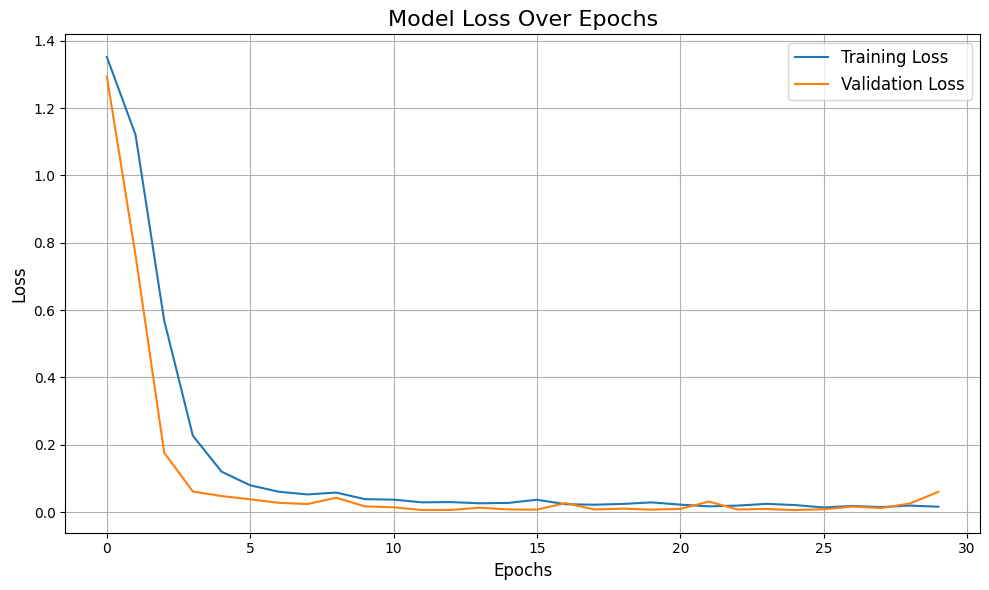

Loss plot saved to plots/loss_plot.svg

Generating and saving accuracy plot...


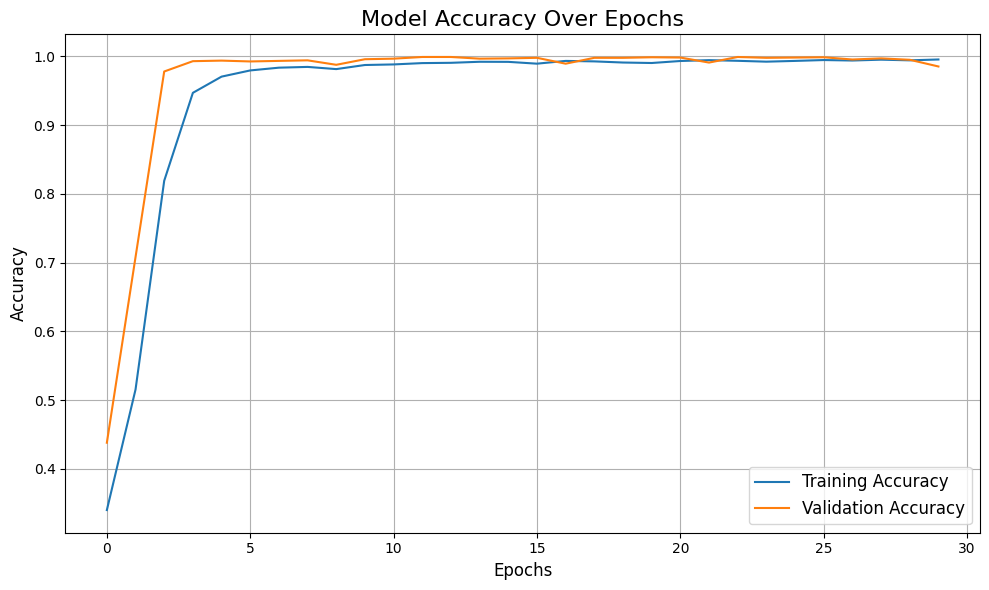

Accuracy plot saved to plots/accuracy_plot.svg

Generating and saving confusion matrix...


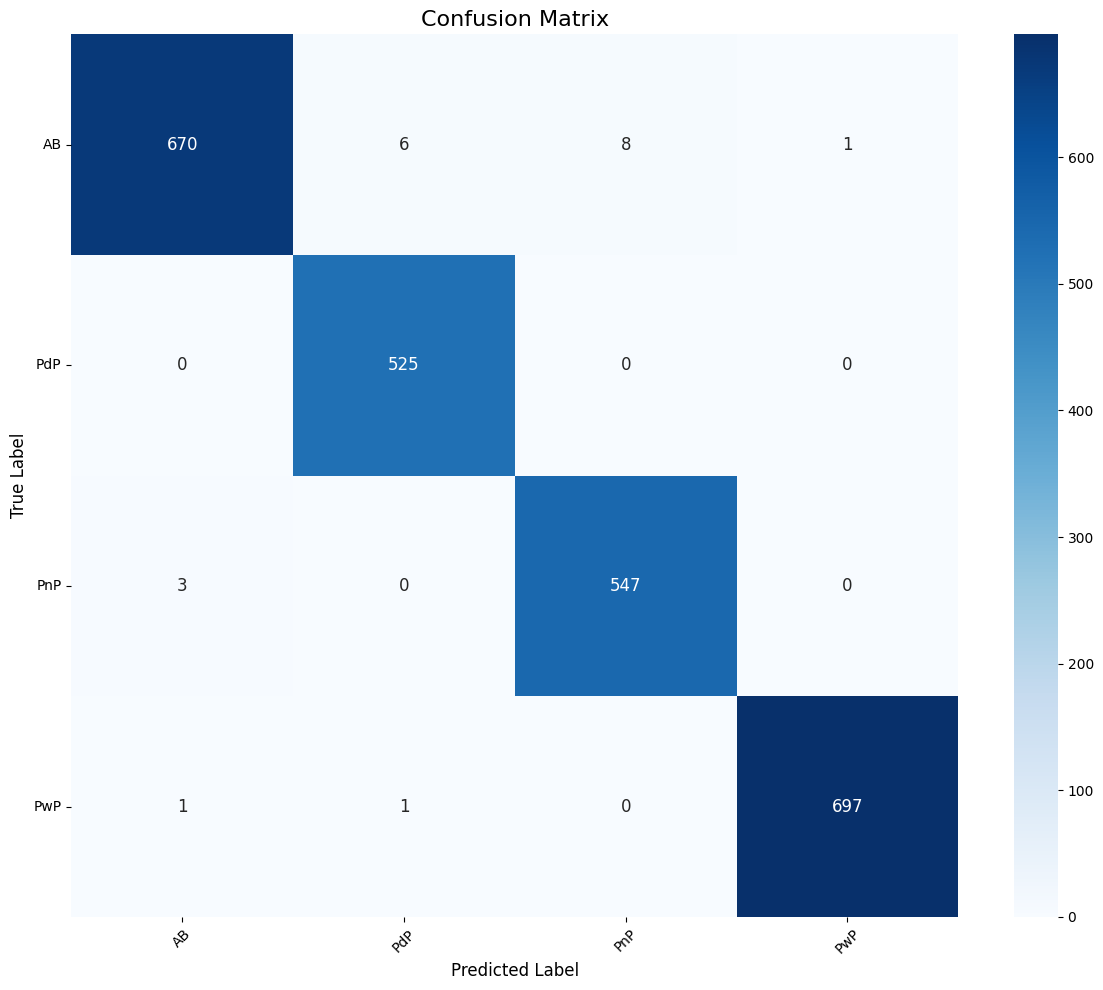

Confusion matrix saved to plots/confusion_matrix.svg


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import os

# This script assumes 'history', 'model', 'test_loader', 'device', and
# 'nb_classes' are available from the preceding training script.

# Define a directory to save the plots
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ==============================================================================
# 1. Plot Loss and Save as SVG
# ==============================================================================
print("Generating and saving loss plot...")
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
loss_filename = os.path.join(output_dir, "loss_plot.svg")
plt.savefig(loss_filename, format='svg')
plt.show()
print(f"Loss plot saved to {loss_filename}")


# ==============================================================================
# 2. Plot Accuracy and Save as SVG
# ==============================================================================
print("\nGenerating and saving accuracy plot...")
plt.figure(figsize=(10, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
accuracy_filename = os.path.join(output_dir, "accuracy_plot.svg")
plt.savefig(accuracy_filename, format='svg')
plt.show()
print(f"Accuracy plot saved to {accuracy_filename}")


# ==============================================================================
# 3. Plot Confusion Matrix and Save as SVG
# ==============================================================================
print("\nGenerating and saving confusion matrix...")

@torch.no_grad()
def get_all_preds(model, loader, device):
    """Function to get all predictions and labels from a dataloader."""
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    all_labels = torch.tensor([], dtype=torch.long).to(device)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

# Get predictions and true labels
y_pred, y_true = get_all_preds(model, test_loader, device)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names for plotting
class_names = ['AB', 'PdP', 'PnP', 'PwP']

# Create a new figure for the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 12})

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
cm_filename = os.path.join(output_dir, "confusion_matrix.svg")
plt.savefig(cm_filename, format='svg')
plt.show()
print(f"Confusion matrix saved to {cm_filename}")

